In [298]:
import numpy as np 
import pandas as pd 
from utility.db_data import connection_db
from utility.datetime_util import create_date_columns
import warnings
warnings.filterwarnings('ignore')

In [299]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

#### Data Preparation

In [300]:
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT * FROM dalmia_sales.sales_data where billing_date > '2021-04-01' and sold_to_party_code between 7000000 and 7099999"

In [301]:
df = connection_db(host= host , database=database, user=user , password=password, sql_query=sql_query)

In [335]:
def return_yoy_df(df):
    df_sales = create_date_columns([df])
    df_sales = df_sales[['sold_to_party_code','Month_Year','bill_quantity']]
    #df_sales =df_sales[df_sales['sold_to_party_code']!='DONATION']
    df_group_month = df_sales.groupby(['sold_to_party_code','Month_Year']).agg({'bill_quantity': ['sum']}).reset_index()
    df_group_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
    pivot_table = pd.pivot_table(df_group_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')
    return pivot_table
pivot = return_yoy_df(df)

In [336]:
pivot = pivot.fillna(0)

In [337]:
def count_zeros_before_first_nonzero(row):
    count = 0
    for value in row:
        if value == 0:
            count += 1
        else:
            break 
    return count
pivot['month_new_dealer'] = pivot.apply(count_zeros_before_first_nonzero , axis = 1)
#table with dealers having atleast 12 months of trend 
dealer_sales = pivot[pivot['month_new_dealer']<=13]

In [338]:
cols = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']
pivot['count_no_transaction'] = (pivot[cols] == 0).astype(int).sum(axis=1)

In [340]:
pivot_1 = pivot[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']]


In [341]:
def count_trailing_zeros_before_end_index(df, end_index):
    counts = []
    for row in df.itertuples(index=False):
        count = 0
        for i in range(end_index - 1, -1, -1):
            if row[i] == 0:
                count += 1
            else:
                break
        counts.append(count)
    return counts

result_matrix = pd.DataFrame(index = dealer_sales.index)
for i in range(len(dealer_sales.columns)):
    string = str(i)
    result_matrix[string] = count_trailing_zeros_before_end_index(dealer_sales, i)
result_matrix.drop('0', axis = 1 , inplace = True)

In [342]:
result_matrix.shape , dealer_sales.shape

((11903, 28), (11903, 29))

In [343]:
#Status of each dealer 
def inactive(value):
    if value == 0: 
        return 'Active'
    elif value == 1: 
        return 'Active_1N'
    elif value == 2: 
        return 'Active_2N'
    elif value == 3: 
        return 'Active_3N'
    elif value>3 and value <=12:
        return 'Inactive'
    else: 
        return 'Churn'
    
for i in result_matrix.columns:
    result_matrix[i] = result_matrix[i].apply(inactive)

In [345]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,month_new_dealer,count_no_transaction
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,0,0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,0,11
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,17
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,27,24
7041477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,27,24
7041478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,27,24


In [400]:
#getting the count of non transaction months
result_matrix['month_new_user'] = dealer_sales['month_new_dealer']
#result_matrix_copy_1 = result_matrix.copy()
for i in range(result_matrix.shape[0]):
    value = result_matrix.iloc[i,28]
    #print(result_matrix_copy_1.iloc[:, :value])  
    result_matrix.iloc[i, :value] = '-'

In [401]:
data

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,month_new_dealer,count_no_transaction,27
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,75.0,90.00,155.00,46.0,111.0,96.0,80.00,0,0,Active
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.00,0.00,0.0,24.0,12.0,24.00,0,11,Active
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0,4,Inactive
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0,17,Churn
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.00,29.00,0.0,27.0,12.0,12.00,13,14,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,92.0,69.95,91.05,41.0,15.0,5.0,20.00,13,13,Active
7036499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.2,195.00,170.00,187.0,235.0,170.5,154.00,13,13,Active
7036501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1005.5,423.00,1055.00,362.5,134.0,223.0,233.00,13,13,Active


In [402]:
data = pivot.merge(result_matrix[['27']], left_index=True , right_index=True , how = 'inner')
data_1 = data.drop(['2023-07','2023-06', '2023-05',
       '2023-04','month_new_dealer', '27'],axis = 1 )

In [403]:
def count_zeros_before_first_nonzero(row):
    count = 0
    for value in row:
        if value == 0:
            count += 1
        else:
            break 
    return count

In [404]:
cols_inv = ['2023-03', '2023-02', '2023-01','2022-12', '2022-11',
       '2022-10', '2022-09', '2022-08', '2022-07', '2022-06', '2022-05',
       '2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11',
       '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05','2021-04']
cols = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']

In [405]:
data_1 = data_1[cols_inv]
data_1['zero_count'] = data_1.apply(count_zeros_before_first_nonzero , axis = 1)

In [406]:
data_1 = data_1[data_1['zero_count']<=13]

In [407]:
test_1

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,state_m,24
Sold To Party Code,,,,,,,,,,,,,,
7000004,91.0,114.0,35.0,22.0,20.0,20.0,20.0,20.0,122.5,75.0,90.0,155.0,Active,Active
7000010,0.0,41.0,24.0,25.0,24.0,25.0,0.0,25.0,17.0,0.0,33.8,12.0,Active_1N,Inactive
7000015,50.0,44.5,15.0,70.5,27.0,75.5,100.0,42.0,54.5,45.0,74.0,27.0,Active_1N,Inactive
7000022,0.0,3.5,3.0,12.0,12.0,24.0,22.0,5.0,21.0,24.0,0.0,29.0,Active_1N,Active
7000025,60.0,100.0,161.0,175.0,75.0,95.0,48.0,108.8,73.0,167.0,137.0,173.0,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,55.0,144.0,100.0,63.0,55.0,70.3,86.8,75.2,92.0,69.95,91.05,Active,Active
7036499,0.0,50.0,350.0,123.0,25.5,103.0,100.5,99.0,50.5,34.2,195.0,170.0,Active,Active
7036501,0.0,113.0,80.5,15.0,7.0,109.0,101.0,141.0,102.0,1005.5,423.0,1055.0,Active,Active


In [408]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,month_new_dealer,count_no_transaction
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,0,0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,0,11
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,17
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,13,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,27,24
7041477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,27,24
7041478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,27,24


In [409]:
test = pd.DataFrame(columns = ['m-1', 'm-2' , 'm-3' , 'm-4', 'm-5' , 'm-6' , 'm-7' , 'm-8' , 
                              'm-9', 'm-10' , 'm-11' , 'm-12'] , index = data_1.index)

In [410]:
for i in range(data_1.shape[0]):
    value = data_1.iloc[i , 24]
    test.iloc[i,] = data_1.iloc[i , value:value+12]

In [411]:
result_matrix_1= result_matrix.merge(test[['m-1']] , left_index=True , right_index=True , how = 'inner')
result_matrix_1.drop(['month_new_user','m-1'],axis =1 , inplace = True)

In [412]:
result_matrix_1['zero_count'] = data_1['zero_count']
y = pd.DataFrame(columns = ['state_m','state_m+1','state_m+2'], index = result_matrix_1.index)
for i in range(result_matrix_1.shape[0]):
    value = result_matrix_1.iloc[i , 28]
    y.iloc[i,] = result_matrix_1.iloc[i , 27-value-3:27-value]

In [413]:
y

,state_m,state_m+1,state_m+2
Sold To Party Code,,,
7000004,Active,Active,Active
7000010,Active_1N,Active_2N,Active_3N
7000015,Active_1N,Active_2N,Active_3N
7000022,Active_1N,Active,Active
7000025,Active,Active,Active
...,...,...,...
7036491,Active,Active,Active
7036499,Active,Active,Active
7036501,Active,Active,Active


In [414]:
cols = ['m-12','m-11','m-10','m-9','m-8','m-7','m-6','m-5','m-4','m-3','m-2','m-1']
test = test[cols]

In [415]:
test = test.merge(pivot['month_new_dealer'], left_index=True , right_index=True , how = 'inner')

In [391]:
test[test['month_new_dealer']==10]

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,month_new_dealer
Sold To Party Code,,,,,,,,,,,,,
7007362,18.0,0.0,15.0,15.0,13.5,15.0,0.0,45.0,55.0,32.5,18.0,25.5,10
7008811,0.0,0.0,0.0,0.0,0.0,18.0,105.5,91.0,153.0,0.0,161.0,69.0,10
7009435,0.0,15.05,0.0,15.0,2.0,18.0,0.0,15.5,12.0,0.0,0.0,12.5,10
7013374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,13.0,12.0,10
7013992,26.25,12.5,0.0,5.0,1.0,32.75,0.0,0.0,0.0,0.0,2.5,6.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035898,50.0,50.0,100.0,50.0,75.0,25.0,25.0,25.0,25.0,25.0,50.0,50.0,10
7035902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,70.5,0.0,13.0,10
7035904,25.0,73.0,175.0,117.0,100.0,205.0,154.0,156.0,302.5,292.0,309.2,118.5,10


In [416]:
test_1 = test.drop('month_new_dealer' , axis = 1 )

#### Inflection point

In [417]:
test_1 = test_1.merge(y['state_m'], left_index=True , right_index=True , how = 'inner')

In [418]:
test_1 = test_1.merge(result_matrix_1['24'], left_index=True , right_index=True, how = 'inner')

In [419]:
test_1

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,state_m,24
Sold To Party Code,,,,,,,,,,,,,,
7000004,91.0,114.0,35.0,22.0,20.0,20.0,20.0,20.0,122.5,75.0,90.0,155.0,Active,Active
7000010,0.0,41.0,24.0,25.0,24.0,25.0,0.0,25.0,17.0,0.0,33.8,12.0,Active_1N,Inactive
7000015,50.0,44.5,15.0,70.5,27.0,75.5,100.0,42.0,54.5,45.0,74.0,27.0,Active_1N,Inactive
7000022,0.0,3.5,3.0,12.0,12.0,24.0,22.0,5.0,21.0,24.0,0.0,29.0,Active_1N,Active
7000025,60.0,100.0,161.0,175.0,75.0,95.0,48.0,108.8,73.0,167.0,137.0,173.0,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,55.0,144.0,100.0,63.0,55.0,70.3,86.8,75.2,92.0,69.95,91.05,Active,Active
7036499,0.0,50.0,350.0,123.0,25.5,103.0,100.5,99.0,50.5,34.2,195.0,170.0,Active,Active
7036501,0.0,113.0,80.5,15.0,7.0,109.0,101.0,141.0,102.0,1005.5,423.0,1055.0,Active,Active


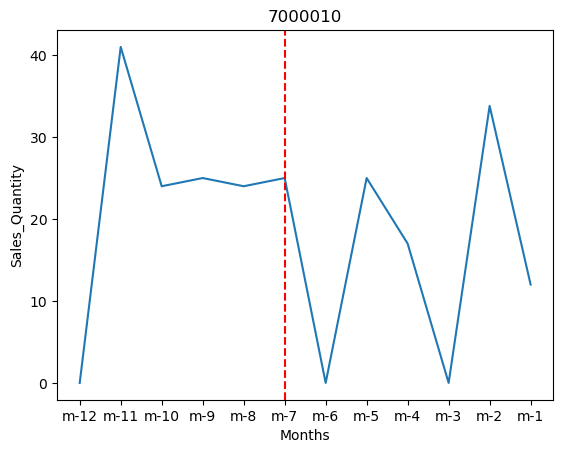

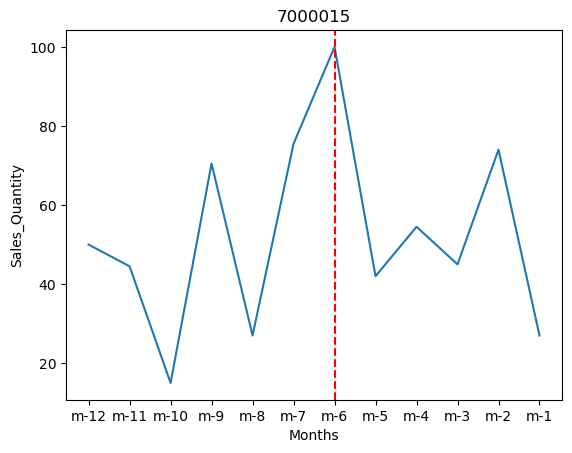

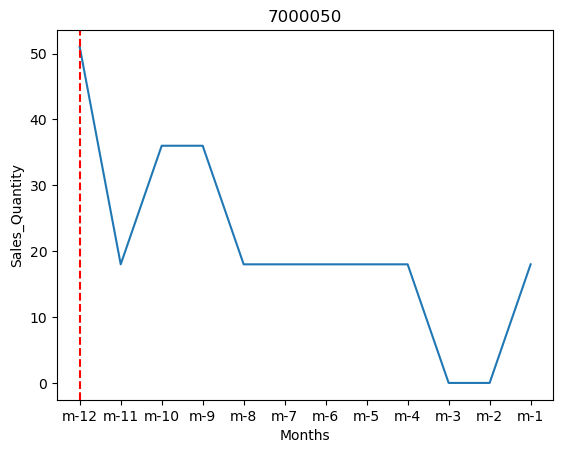

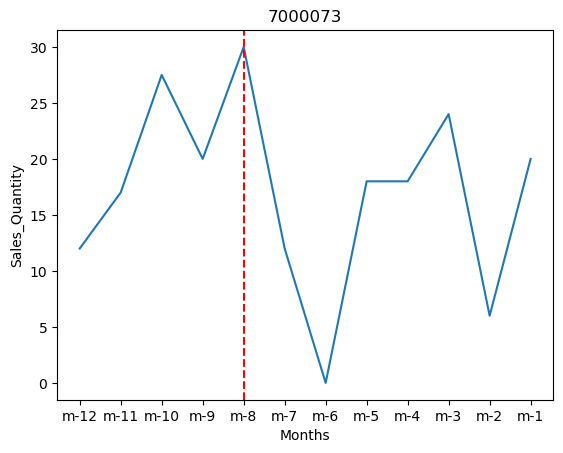

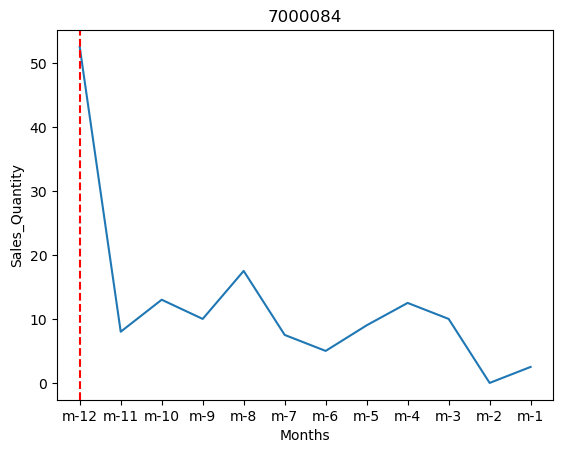

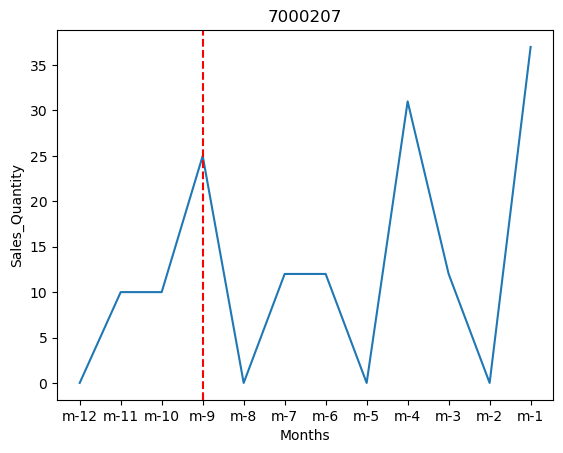

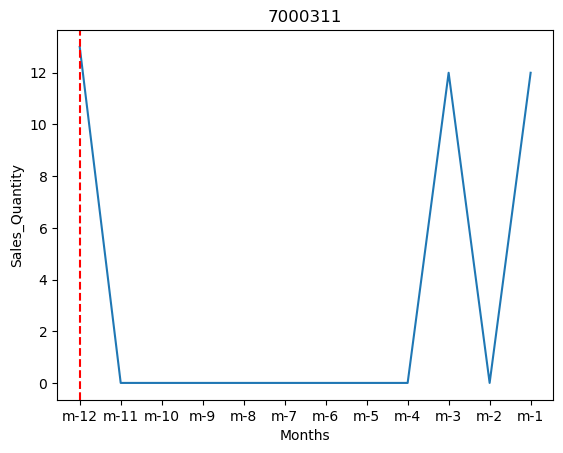

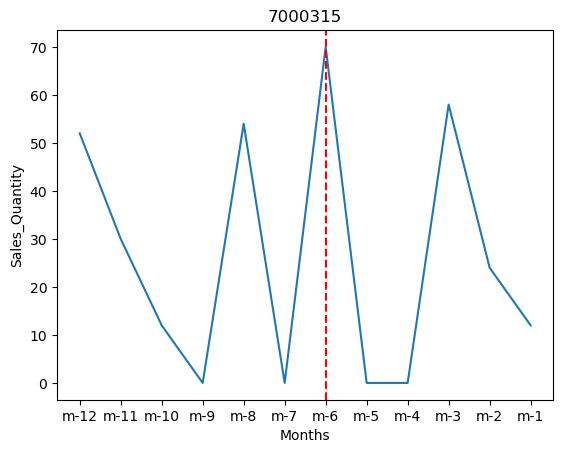

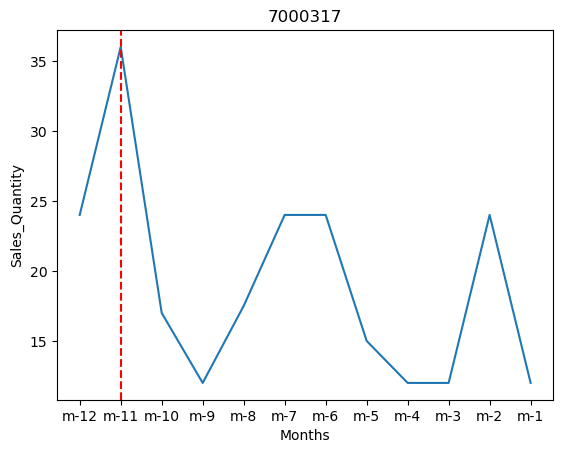

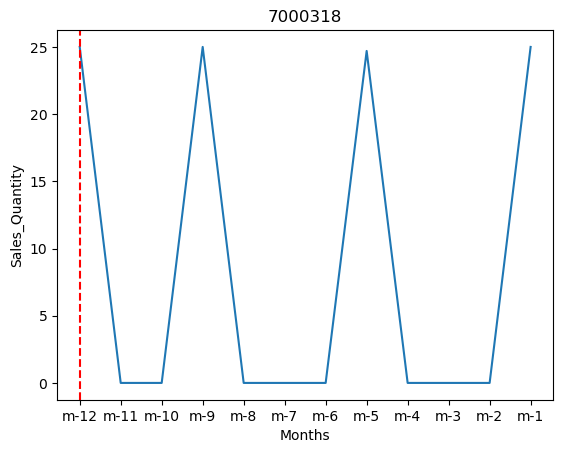

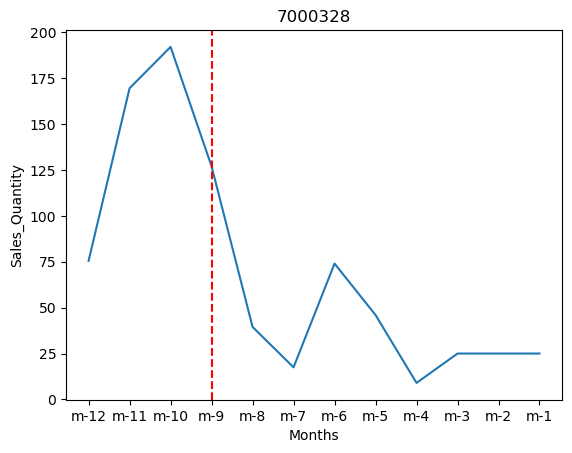

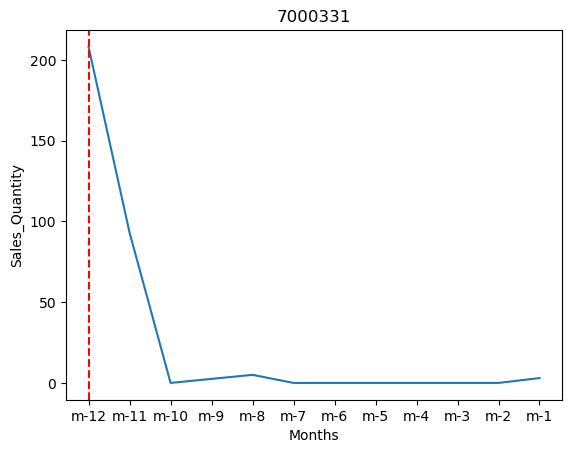

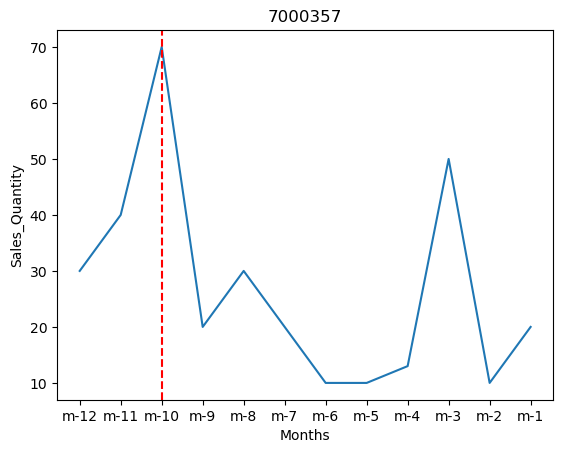

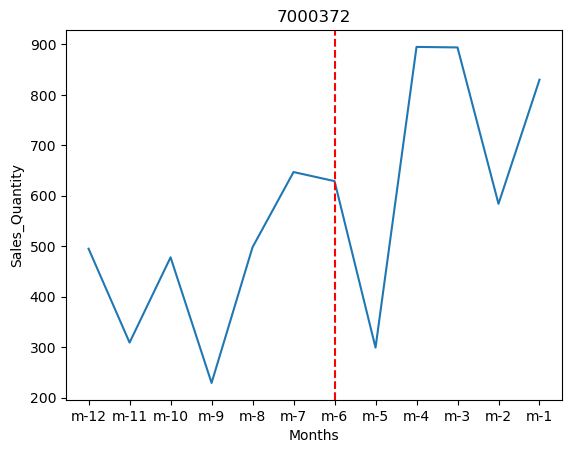

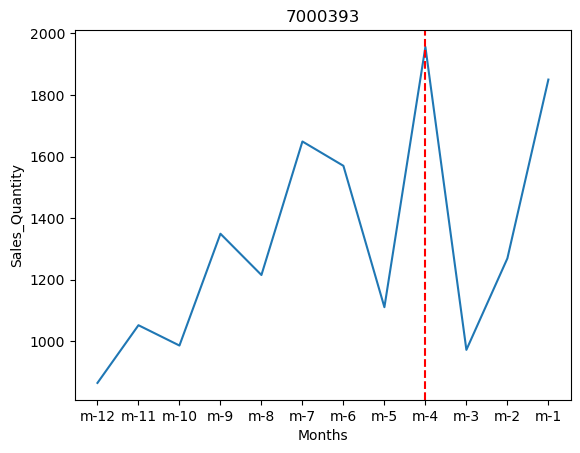

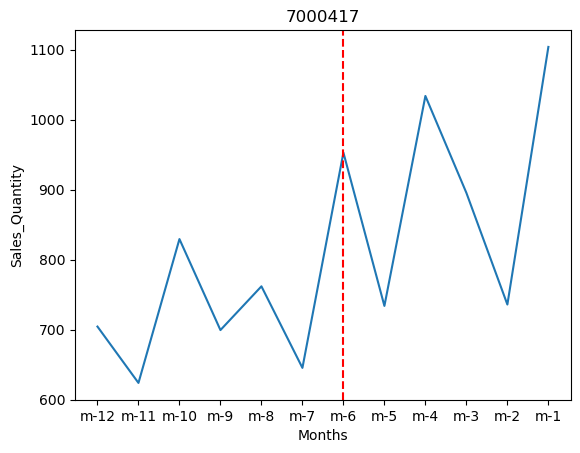

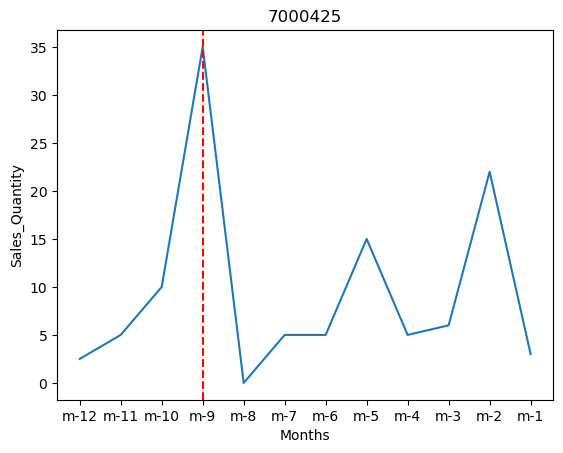

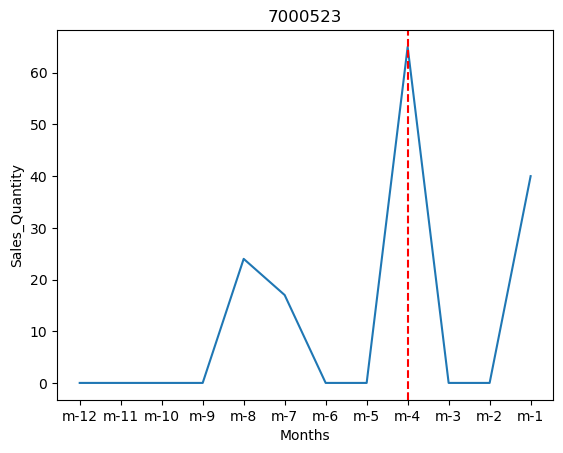

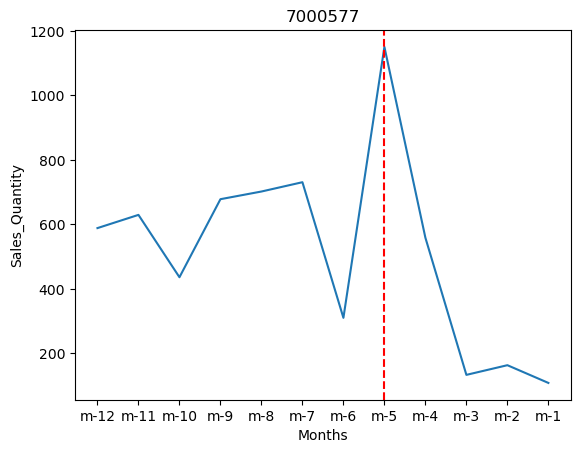

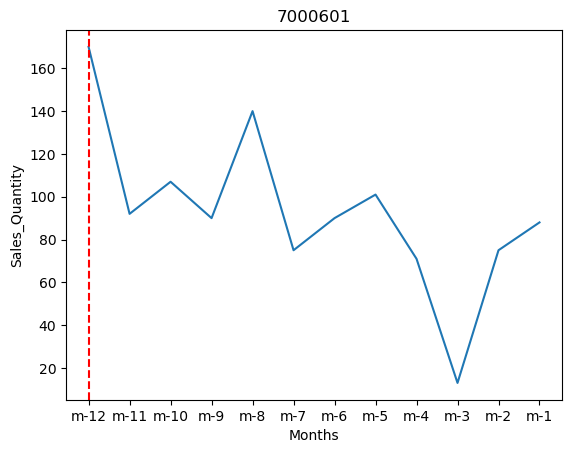

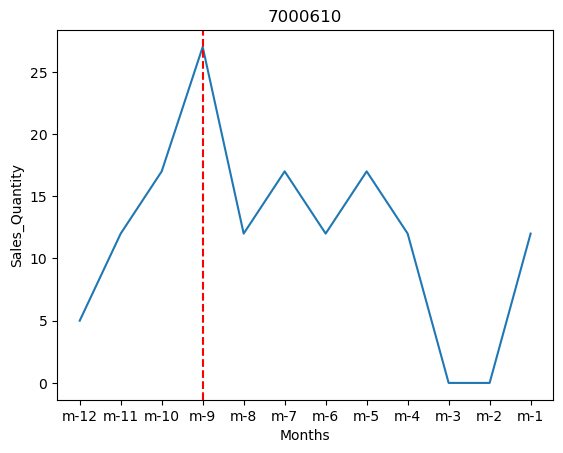

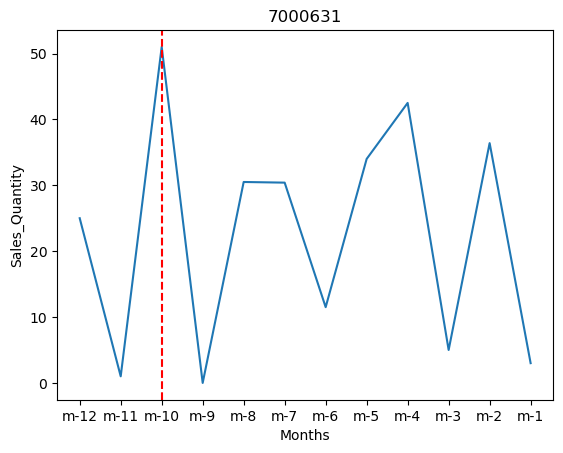

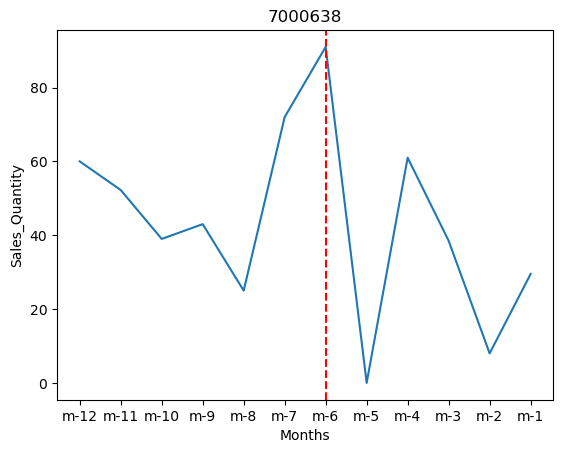

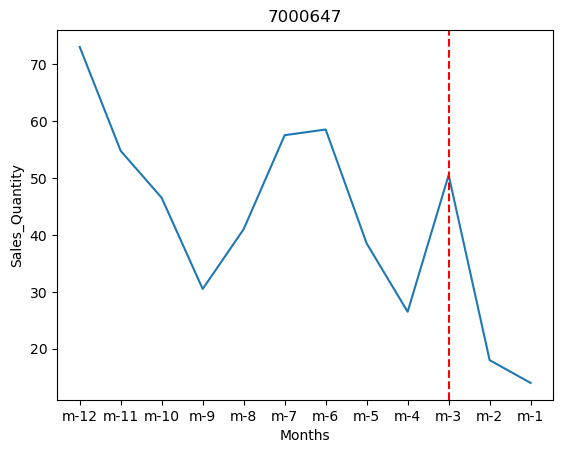

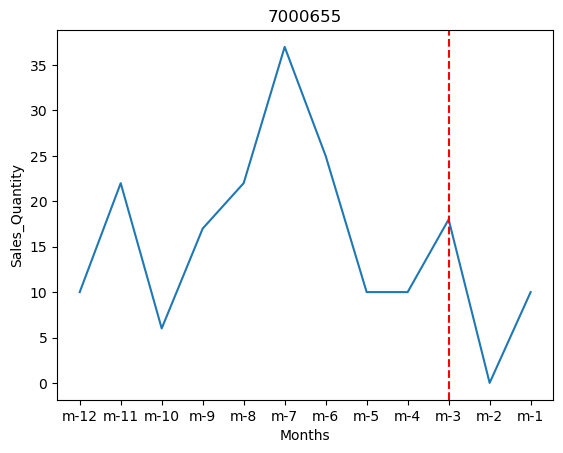

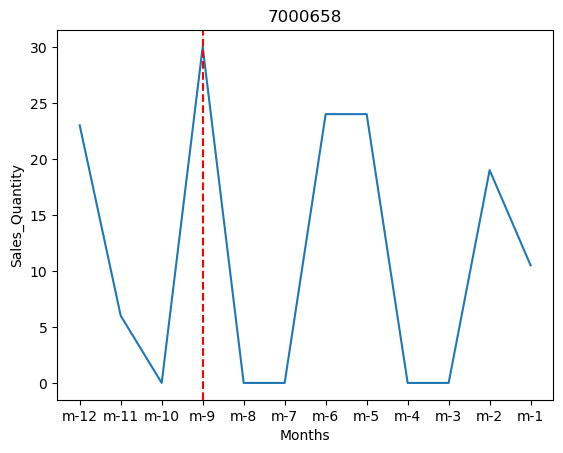

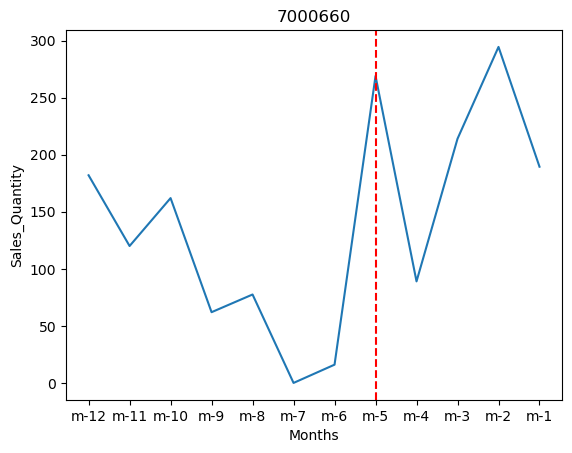

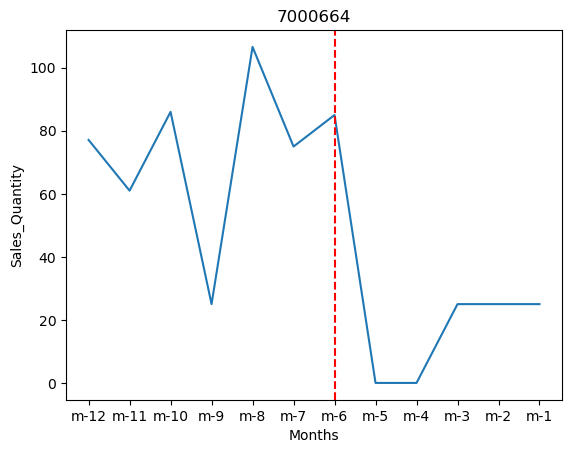

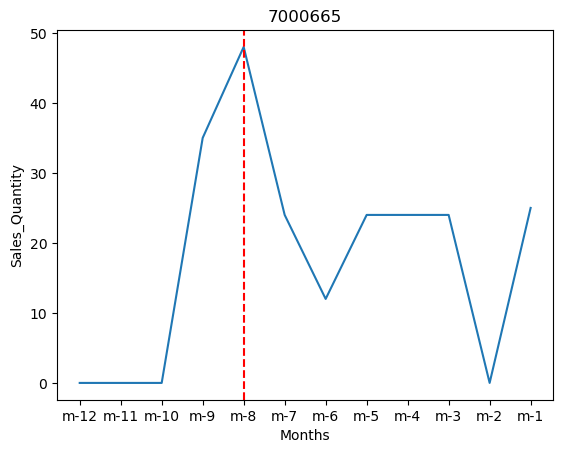

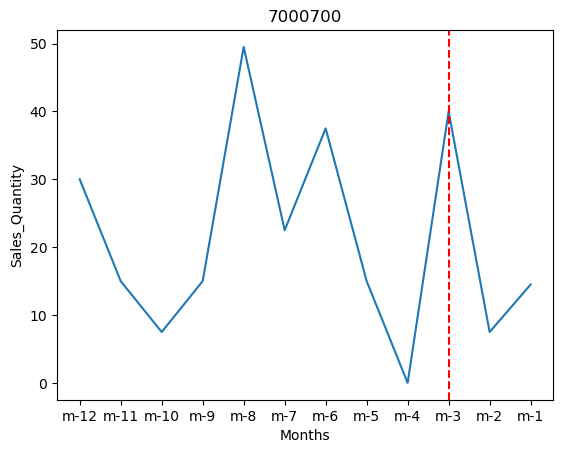

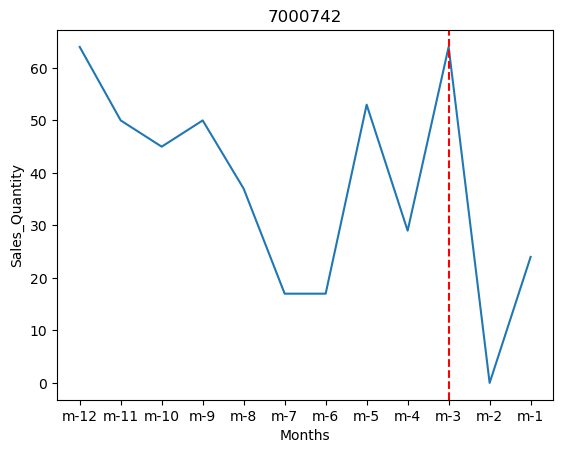

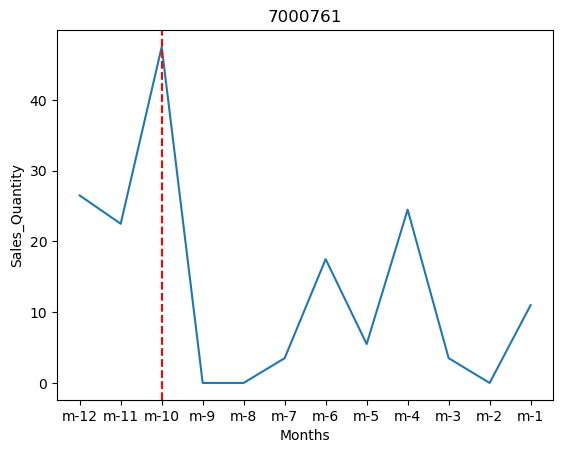

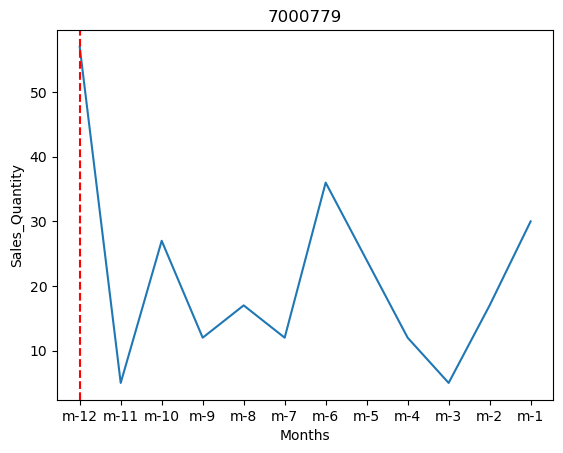

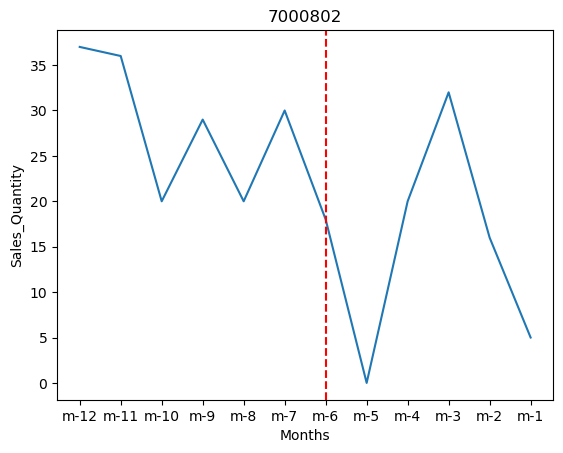

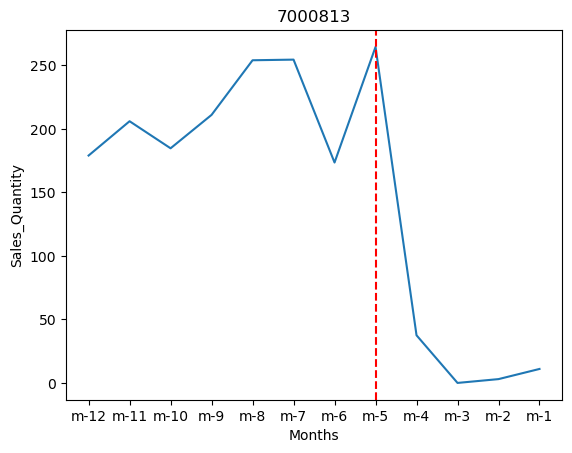

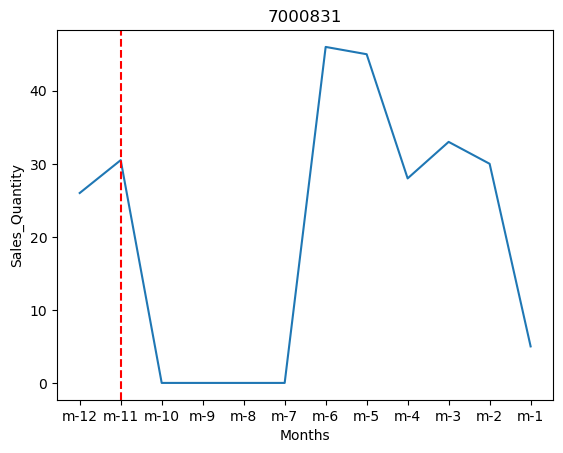

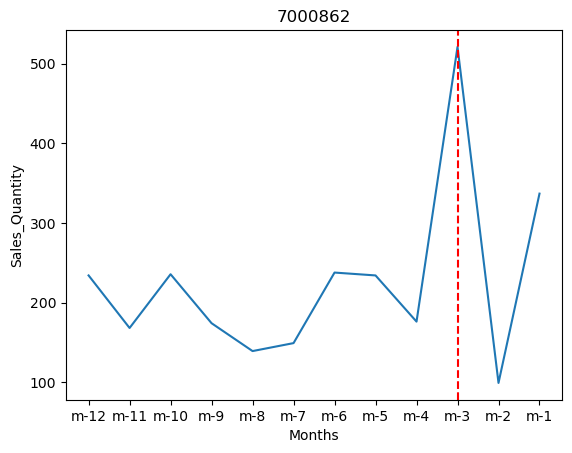

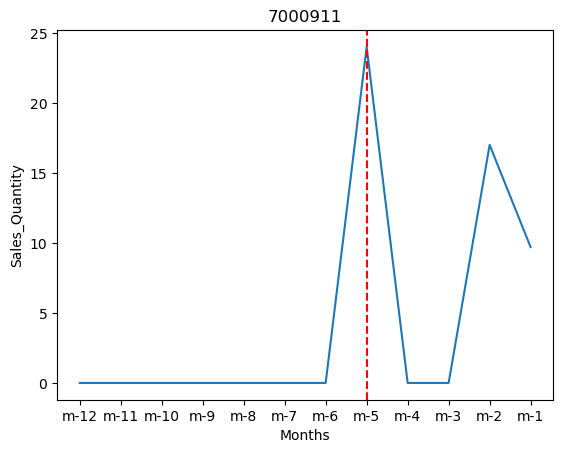

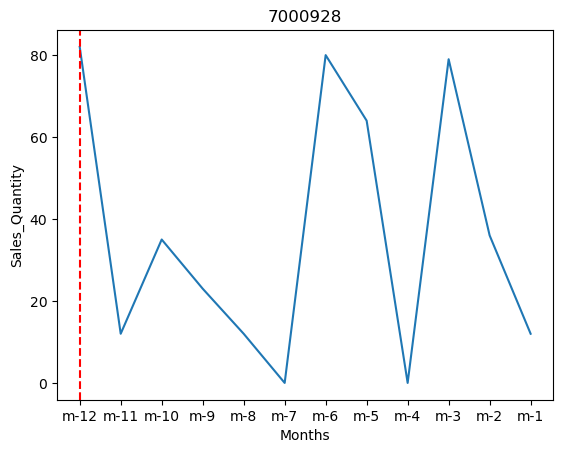

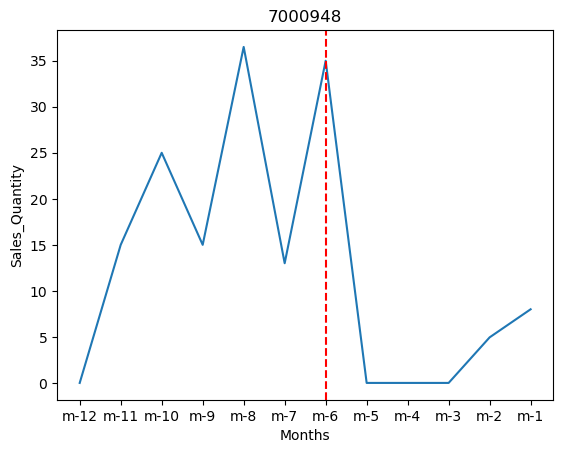

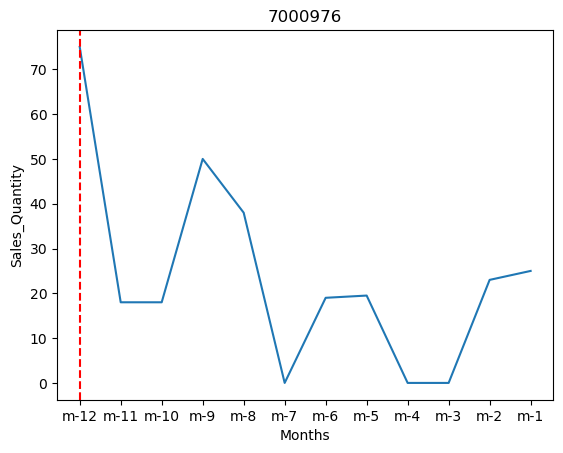

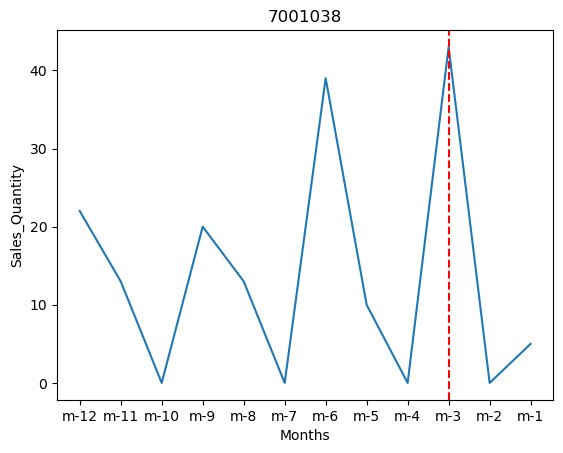

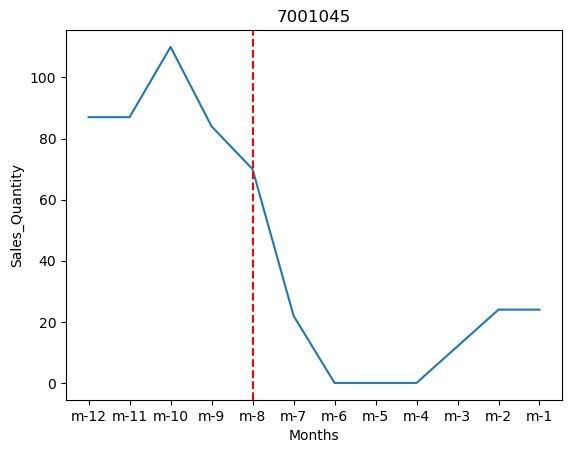

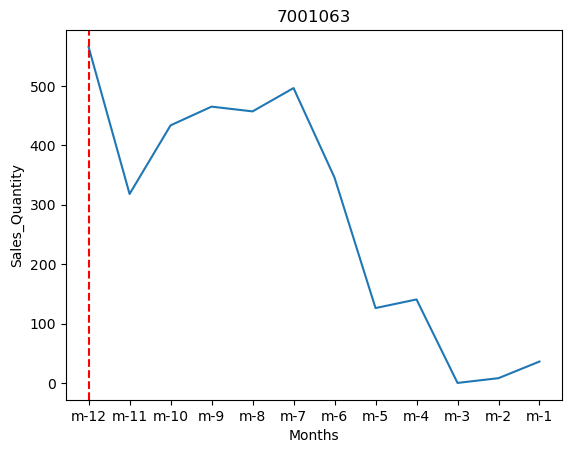

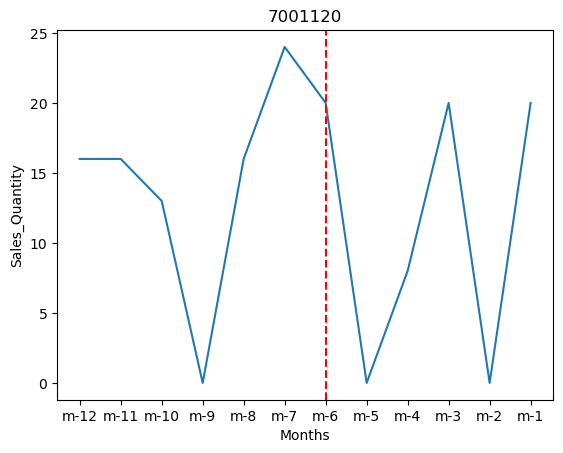

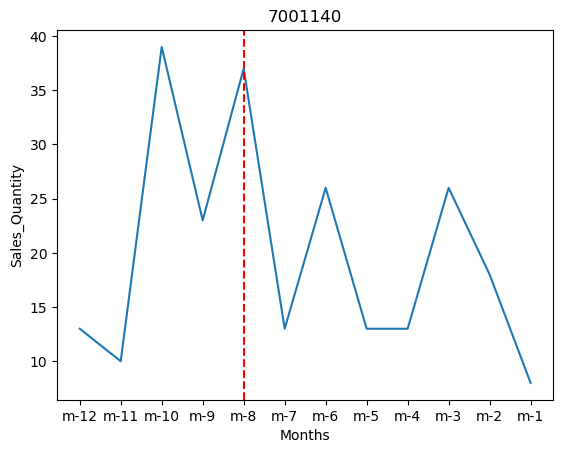

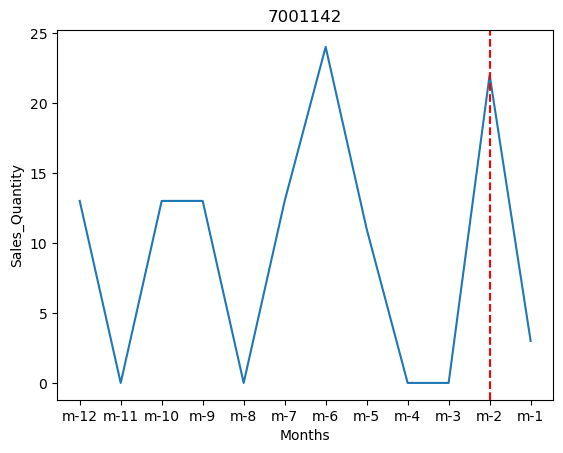

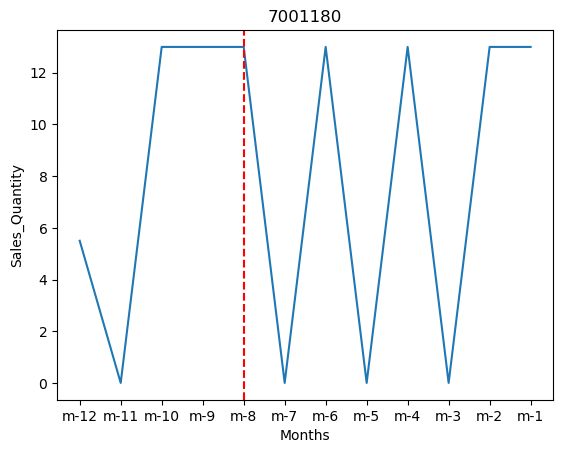

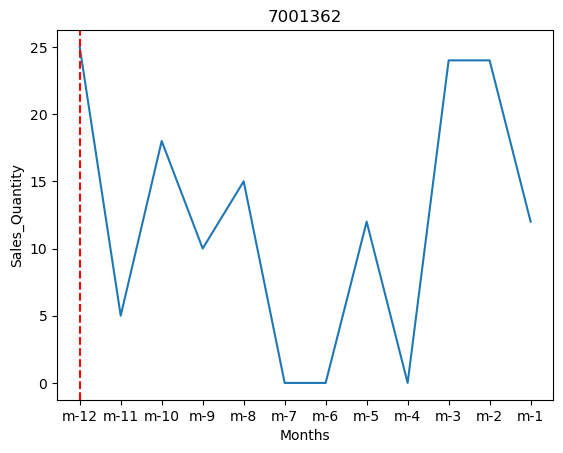

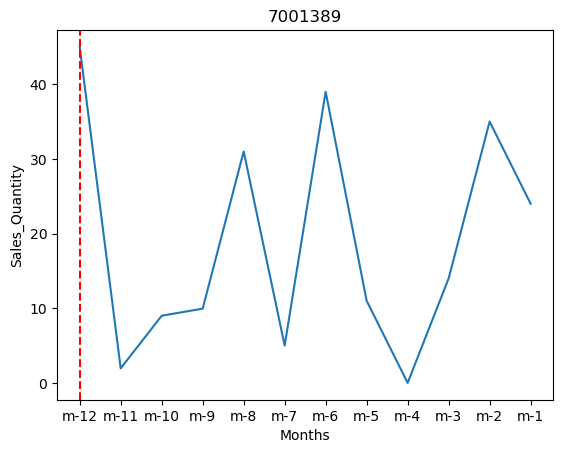

In [420]:
import matplotlib.pyplot as plt





def index_i(x):
    if x ==0:
        cp = 'm-12'
    if x==1:
        cp = 'm-12'
    if x ==2:
        cp = 'm-11'
    if x==3:
        cp = 'm-10'
    if x ==4:
        cp = 'm-9'
    if x==5:
        cp = 'm-8'
    if x ==6:
        cp = 'm-7'
    if x==7:
        cp = 'm-6'
    if x==8:
        cp = 'm-5'
    if x ==9:
        cp = 'm-4'
    if x==10:
        cp = 'm-3'
    if x ==11:
        cp = 'm-2'
    return cp


test_2 = test_1[test_1['24'].isin(['Inactive','Churn'])][cols]
for g in test_2.head(50).index:
    row = test_2.loc[g]
    maxi = row.max()
    list_i = [0]
    for i in range(len(row.values)-1):
        a = row.values[i+1]-row.values[i]
        list_i.append(a)
    for i in range(len(list_i)): 
        list_i[i] = list_i[i]/maxi
    min_i = list_i.index(min(list_i))
    list_i.remove(max(list_i))

    # Get the index of the second-highest element
    min_2i = list_i.index(max(list_i))
    min_id = index_i(min_i)
    min_2id = index_i(min_2i)

    plt.plot(row)
    plt.axvline(min_id, color='red', linestyle='dashed', label='min_inflection')
    #plt.axvline(min_2id, color='green', linestyle='dashed', label='max_inflection')
    plt.xlabel('Months')
    plt.ylabel('Sales_Quantity')
    plt.title(g)
    plt.show()

#### Segment

In [369]:
def rating_level(number):
    if number < -0.3:
        return 0
    if number>=-0.3 and number < -0.15:
        return 1
    if number>=-0.15 and number < 0.15:
        return 2
    if number>=0.15 and number <0.3:
        return 3
    if number>=0.3:
        return 4
def rating_slope(number):
    if number < -0.3:
        return 0
    if number>=-0.3 and number < -0.15:
        return 1
    if number>=-0.15 and number<0:
        return 2
    if number>=0 and number < 0.15:
        return 2
    if number>=0.15 and number<0.3:
        return 3
    if number >= 0.3:
        return 4

In [423]:
test_1['24'].value_counts()

Active       7529
Inactive     1713
Active_1N     402
Active_3N     194
Active_2N     174
Churn         121
Name: 24, dtype: int64

In [426]:
test_2 = test_2[test_2.index.isin(churn_df_1.index)]

In [428]:
test_2.to_csv('churn_volume_updated.csv')

In [429]:
data_1

,2023-03,2023-02,2023-01,2022-12,2022-11,2022-10,2022-09,2022-08,2022-07,2022-06,...,2021-12,2021-11,2021-10,2021-09,2021-08,2021-07,2021-06,2021-05,2021-04,zero_count
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,155.00,90.00,75.0,122.5,20.0,20.0,20.0,20.0,22.00,35.0,...,76.0,25.0,43.0,74.5,73.5,102.0,207.0,85.0,255.5,0
7000010,0.00,0.00,0.0,0.0,0.0,0.0,0.0,12.0,33.80,0.0,...,25.0,24.0,41.0,0.0,30.0,24.0,0.0,37.0,57.0,7
7000015,0.00,0.00,0.0,0.0,27.0,74.0,45.0,54.5,42.00,100.0,...,50.0,77.0,70.5,68.5,91.0,62.0,63.0,50.0,4.0,4
7000022,29.00,0.00,24.0,21.0,5.0,22.0,24.0,12.0,12.00,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7000025,173.00,137.00,167.0,73.0,108.8,48.0,95.0,75.0,175.00,161.0,...,60.0,117.0,107.0,102.0,107.5,105.0,87.0,108.5,98.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,91.05,69.95,92.0,75.2,86.8,70.3,55.0,63.0,100.00,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7036499,170.00,195.00,34.2,50.5,99.0,100.5,103.0,25.5,123.00,350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7036501,1055.00,423.00,1005.5,102.0,141.0,101.0,109.0,7.0,15.00,80.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [430]:
churn_df = churn_df+1

In [431]:
# churn_df['s_1'] = (churn_df.iloc[:,-1] - churn_df.iloc[:,-2])/churn_df.iloc[:,-2]
# churn_df['s_2'] = (churn_df.iloc[:,-3] - churn_df.iloc[:,-4])/churn_df.iloc[:,-4]
churn_df['change_q2'] = (churn_df.iloc[:,-1]-churn_df.iloc[:,-3])/churn_df.iloc[:,-3:].max(axis = 1)
churn_df['level_2'] = churn_df.iloc[:,6:12].sum(axis = 1)/6
churn_df['level_1'] = churn_df.iloc[:,0:6].sum(axis = 1)/6
churn_df['change_l'] = (churn_df['level_2']-churn_df['level_1'])/churn_df['level_1']




In [438]:
churn_df

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,change_q2,level_2,level_1,change_l,cluster,mean_qty
Sold To Party Code,,,,,,,,,,,,,,,,,,
7000010,2.0,43.0,26.0,27.0,26.0,27.0,2.0,27.0,19.0,2.0,35.8,14.0,4,16.633333,25.166667,0,5,20.900000
7000015,52.0,46.5,17.0,72.5,29.0,77.5,102.0,44.0,56.5,47.0,76.0,29.0,4,59.083333,49.083333,3,17,54.083333
7000050,53.0,20.0,38.0,38.0,20.0,20.0,20.0,20.0,20.0,2.0,2.0,20.0,4,14.000000,31.500000,0,5,22.750000
7000073,14.0,19.0,29.5,22.0,32.0,14.0,2.0,20.0,20.0,26.0,8.0,22.0,4,16.333333,21.750000,1,7,19.041667
7000084,54.5,10.0,15.0,12.0,19.5,9.5,7.0,11.0,14.5,12.0,2.0,4.5,4,8.500000,20.083333,0,1,14.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036427,2.0,2.0,2.0,2.0,2.0,2.0,17.0,2.0,2.0,2.0,2.0,17.0,2,7.000000,2.000000,4,25,4.500000
7036436,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,27.0,67.0,3,17.000000,2.000000,4,25,9.500000
7036438,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,54.0,135.0,4,32.833333,2.000000,4,25,17.416667


In [433]:
churn_df[churn_df['change_l']<= -0.6].head(20)

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,change_q2,level_2,level_1,change_l,cluster,mean_qty
Sold To Party Code,,,,,,,,,,,,,,,,,,
7000328,77.5,171.5,194.0,129.0,41.5,19.5,76.0,48.0,11.0,27.0,27.0,27.0,0.985866,36.000000,105.500000,-0.658768,3,70.750000
7000331,210.0,95.0,2.0,4.5,7.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,0.964232,2.500000,53.416667,-0.953198,5,27.958333
7000664,79.1,63.0,88.0,27.0,108.6,77.0,87.0,2.0,2.0,27.0,27.0,27.0,0.980478,28.666667,73.783333,-0.611475,3,51.225000
7000813,181.0,208.0,186.7,213.0,256.0,256.5,175.5,266.5,39.5,2.0,5.0,13.0,0.993343,83.583333,216.866667,-0.614587,5,150.225000
7001045,89.0,89.0,112.0,86.0,72.0,24.0,2.0,2.0,2.0,14.0,26.0,26.0,0.977941,12.000000,78.666667,-0.847458,5,45.333333
7001063,567.5,320.0,435.5,467.0,459.0,498.25,347.5,128.0,142.5,2.0,10.0,38.0,0.996486,111.333333,457.875000,-0.756848,5,284.604167
7001490,38.0,56.0,20.0,2.0,14.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,0.920000,3.000000,22.000000,-0.863636,5,12.500000
7001683,267.85,107.5,214.0,49.0,7.0,2.0,4.5,7.0,2.0,9.5,2.0,5.5,0.982297,5.083333,107.891667,-0.952885,1,56.487500
7002022,222.0,82.0,42.0,2.0,12.0,2.0,52.0,2.0,32.0,12.0,2.0,12.0,0.974684,18.666667,60.333333,-0.690608,3,39.500000


In [434]:
#churn_df = churn_df.replace([np.NaN,np.inf],0)

In [435]:
churn_df['change_l'] = churn_df['change_l'].apply(rating_level)

In [436]:
churn_df['change_q2'] = churn_df['change_q2'].apply(rating_slope)

In [437]:
churn_df['change_q2'].value_counts()

4    1288
2     299
3     126
Name: change_q2, dtype: int64

In [89]:
def cluster(df):
   
    if df['change_l']==0 and df['change_q2']==0:
        return 0
    if df['change_l']==0 and df['change_q2']==1:
        return 1
    if df['change_l']==0 and df['change_q2']==2:
        return 2
    if df['change_l']==0 and df['change_q2']==3:
        return 3
    if df['change_l']==0 and df['change_q2']==4:
        return 4
    if df['change_l']==1 and df['change_q2']==0:
        return 5
    if df['change_l']==1 and df['change_q2']==1:
        return 6
    if df['change_l']==1 and df['change_q2']==2:
        return 7
    if df['change_l']==1 and df['change_q2']==3:
        return 8
    if df['change_l']==1 and df['change_q2']==4:
        return 9
    if df['change_l']==2 and df['change_q2']==0:
        return 10
    if df['change_l']==2 and df['change_q2']==1:
        return 11
    if df['change_l']==2 and df['change_q2']==2:
        return 12
    if df['change_l']==2 and df['change_q2']==3:
        return 13
    if df['change_l']==2 and df['change_q2']==4:
        return 14
    if df['change_l']==3 and df['change_q2']==0:
        return 15
    if df['change_l']==3 and df['change_q2']==1:
        return 16
    if df['change_l']==3 and df['change_q2']==2:
        return 17
    if df['change_l']==3 and df['change_q2']==3:
        return 18
    if df['change_l']==3 and df['change_q2']==4:
        return 19
    if df['change_l']==4 and df['change_q2']==0:
        return 20
    if df['change_l']==4 and df['change_q2']==1:
        return 21
    if df['change_l']==4 and df['change_q2']==2:
        return 22
    if df['change_l']==4 and df['change_q2']==3:
        return 23
    if df['change_l']==4 and df['change_q2']==4:
        return 24

In [90]:
churn_df['cluster'] = churn_df[['change_l','change_q2']].apply(cluster , axis = 1) 

In [91]:
churn_df_group = churn_df.groupby('cluster').agg({'cluster': ['count']}).reset_index()

In [92]:
churn_df_group.columns = ['cluster', 'count']

In [488]:
dealer_sales_1

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,41.0,91.0,114.0,35.0,22.0,20.0,20.0,20.0,20.0,122.50
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,25.0,17.0,0.0,33.8,12.0,0.0,0.0,0.0,0.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,70.5,27.0,75.5,100.0,42.0,54.5,45.0,74.0,27.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000025,98.0,108.5,87.0,105.0,107.5,102.0,107.0,117.0,60.0,85.0,...,140.0,60.0,100.0,161.0,175.0,75.0,95.0,48.0,108.8,73.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034425,0.0,0.0,0.0,45.0,100.0,55.0,85.0,65.9,140.0,0.0,...,90.0,90.0,30.0,150.0,0.0,0.0,0.0,0.0,0.0,90.00
7034429,0.0,0.0,0.0,63.0,53.0,222.0,265.0,203.1,321.0,365.5,...,409.0,73.5,206.5,187.0,141.0,253.5,181.5,198.5,232.0,116.65
7034432,0.0,0.0,0.0,25.0,75.0,55.0,25.0,34.7,70.0,63.0,...,63.5,125.0,57.0,107.0,105.0,50.0,60.0,60.0,55.0,30.00


In [481]:
dealer_sales_1 = dealer_sales[dealer_sales['month_new_dealer']<4]
dealer_sales_1 = dealer_sales_1.drop('month_new_dealer', axis = 1)
dealer_sales_1 = dealer_sales_1[['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12']]
dict_i =  {0:'Mar_2022',1:'Apr_2022',2:'May_2022',3:'Jun_2022',4:'Jul_2022',5:'Aug_2022',6:'Sep_2022',
             7:'Oct_2022',8:'Nov_2022',9:'Dec_2022'}   
df_1 = pd.DataFrame()
df_1['cluster'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
df_1['Level'] = ['High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise']
df_1['Slope'] = ['High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise']

for i in range(10):
    df = dealer_sales_1.iloc[:,i:i+12]
    df = df+1
    df = df.merge(result_matrix_1[[str(i+12),'24']], left_index = True, right_index = True, how = 'inner')
    df = df[(df[str(i+12)]=='Active')&df['24'].isin(['Inactive','Churn'])]
    df.drop(str(i+12), axis = 1 , inplace = True)
    print(df.shape)
    df['l1'] = df.iloc[:,0:6].sum(axis =1 )/6
    df['l2'] = df.iloc[:,6:12].sum(axis=1)/6
    df['change_l'] = (df['l2']-df['l1'])/df['l1']
    df['change_q2'] = (df.iloc[:,-5] - df.iloc[:,-7])/df.iloc[:,-7:-5].max(axis=1)
    df['change_l'] = df['change_l'].apply(rating_level)
    df['change_q2'] = df['change_q2'].apply(rating_slope)
    df['cluster'] = df[['change_l','change_q2']].apply(cluster , axis = 1) 
    df_groupby = df.groupby('cluster').agg({'cluster': ['count']}).reset_index()
    df_groupby.columns = ['cluster' , dict_i[i]]
    #print(df_groupby)
    df_1 = df_1.merge(df_groupby , left_on='cluster' , right_on = 'cluster' , how = 'left')

(876, 13)
(688, 13)
(623, 13)
(521, 13)
(485, 13)
(348, 13)
(281, 13)
(185, 13)
(113, 13)
(0, 13)


In [482]:
df_1 = df_1.merge(churn_df_group , left_on='cluster', right_on = 'cluster', how = 'inner')

In [483]:
df_1 = df_1.rename(mapper = {'count':'churn'} , axis = 1)

In [485]:
df_1.drop('Dec_2022', axis = 1 , inplace = True)

In [490]:
df_1 = df_1.fillna(0)

In [491]:
df_1.to_csv('segment_3.csv')

In [255]:
df_1 = df_1.merge(churn_df , left_on = 'cluster' , right_on = 'cluster' , how = 'inner')

In [103]:
churn_df

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,change_q2,level_2,level_1,change_l,cluster
Sold To Party Code,,,,,,,,,,,,,,,,,
7000010,1.0,42.0,25.0,26.0,25.0,26.0,1.0,26.0,18.0,1.0,34.8,13.0,4,15.633333,24.166667,0,4
7000015,51.0,45.5,16.0,71.5,28.0,76.5,101.0,43.0,55.5,46.0,75.0,28.0,1,58.083333,48.083333,3,16
7000050,52.0,19.0,37.0,37.0,19.0,19.0,19.0,19.0,19.0,1.0,1.0,19.0,4,13.000000,30.500000,0,4
7000073,13.0,18.0,28.5,21.0,31.0,13.0,1.0,19.0,19.0,25.0,7.0,21.0,1,15.333333,20.750000,1,6
7000084,53.5,9.0,14.0,11.0,18.5,8.5,6.0,10.0,13.5,11.0,1.0,3.5,0,7.500000,19.083333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036427,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1.0,1.0,1.0,16.0,4,6.000000,1.000000,4,24
7036436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.0,66.0,4,16.000000,1.000000,4,24
7036438,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,53.0,134.0,4,31.833333,1.000000,4,24


In [108]:
churn_df['mean_qty']=churn_df.iloc[:,0:12].mean(axis = 1)

In [110]:
churn_df_volume = churn_df.groupby('cluster').agg({'mean_qty': ['mean']}).reset_index()

In [112]:
churn_df_volume.columns = ['cluster' , 'mean_qty']

In [143]:
discount_east = pd.read_excel('data/East_Discount_Dealer.xlsx')
discount_south = pd.read_excel('data/South_Discount_Dealer.xlsx')
discount_NE = pd.read_excel('data/NE_Discount_Dealer.xlsx')

In [144]:
discount = pd.concat([discount_east,discount_NE,discount_south], axis = 0)

In [197]:
discount

,Sales_Region,Dealer_ID,Month,Discount,Total_Discount,Price_Support
0,CENTRAL,7023602,01'23,8700.000000,8700.000000,0.0
1,CENTRAL,7023602,02'23,13388.480000,16670.480000,3282.0
2,CENTRAL,7023602,03'23,4026.960000,5433.960000,1407.0
3,CENTRAL,7023677,02'23,2700.000000,4263.000000,1563.0
4,CENTRAL,7023710,01'23,5750.000000,5750.000000,0.0
...,...,...,...,...,...,...
62677,SOUTH,7039805,08'22,12.780908,12.780908,0.0
62678,SOUTH,7039805,09'22,12.780908,12.780908,0.0
62679,SOUTH,7039805,10'22,12.780908,12.780908,0.0
62680,SOUTH,7039805,11'22,12.780908,12.780908,0.0


In [227]:
discount_month = discount.groupby(['Dealer_ID','Month']).agg({'Total_Discount': ['sum']}).reset_index()
discount_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_discount = pd.pivot_table(discount_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')

In [228]:
pivot_table_discount.columns = ['2023-01','2022-02','2023-02','2022-03','2023-03','2022-04','2022-05',
                               '2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12']

In [229]:
cols = ['2022-02','2022-03','2022-04','2022-05',
        '2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12','2023-01',
       '2023-02','2023-03']
pivot_table_discount = pivot_table_discount[cols]

In [230]:
pivot_table_discount = pivot_table_discount.fillna(0)

In [231]:
pivot_table_discount

,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
Sold To Party Code,,,,,,,,,,,,,,
7000004,0.0,0.0,58638.080000,53390.907500,13872.200000,12789.410000,12557.500000,6107.500000,24410.833333,24348.833333,73613.353333,67405.280000,82557.601600,88128.287200
7000010,0.0,0.0,17500.000000,7830.620000,0.000000,17294.730000,6986.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7000015,0.0,0.0,26399.340000,56216.512500,62050.826300,27085.045300,38413.882500,20554.667500,24038.457800,17762.312500,0.000000,15070.000000,0.000000,0.000000
7000022,0.0,0.0,256.666667,1342.760467,963.992967,4631.744767,6078.026067,11154.146667,9349.291667,1677.104167,11594.455767,5195.846667,256.666667,6639.940067
7000025,0.0,0.0,73661.340000,76702.000000,100248.200000,135719.132500,74984.812500,71291.062500,36755.666667,77940.666667,46073.104167,82412.882800,93254.437500,85480.484400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039796,0.0,0.0,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,11137.630192
7039799,0.0,0.0,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,1006.203908
7039800,0.0,0.0,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,26598.746225,26598.746225,27548.746225


In [204]:
pivot_table_discount[pivot_table_discount.index.isin(churn_df.index)]

,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
Sold To Party Code,,,,,,,,,,,,,,
7000010,0.0,0.0,17500.000000,7830.620000,0.000000,17294.730000,6986.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7000015,0.0,0.0,26399.340000,56216.512500,62050.826300,27085.045300,38413.882500,20554.667500,24038.457800,17762.312500,0.000000,15070.000000,0.000000,0.000000
7000073,0.0,0.0,2902.480000,7987.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7000084,0.0,0.0,6072.500000,5007.780000,2962.480000,0.000000,1053.115000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7000315,0.0,0.0,13050.000000,5527.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036418,0.0,0.0,0.000000,11280.312500,5635.000000,11085.052500,427.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7036421,0.0,0.0,4433.552125,10508.552125,11525.352125,13688.912125,9740.472125,8746.032125,462.032125,462.032125,462.032125,462.032125,462.032125,462.032125
7036427,0.0,0.0,0.000000,1106.250000,0.000000,0.000000,0.000000,0.000000,1612.500000,0.000000,0.000000,0.000000,0.000000,0.000000


In [205]:
discount_22_east = pd.read_excel('data/East_Discount_FY-22.xlsx')
discount_22_ne = pd.read_excel('data/NE_Discount_FY-22.xlsx')
discount_22_south = pd.read_excel('data/South_Discount_FY-22.xlsx')

In [206]:
discount_22_south.columns

Index(['Unnamed: 0', 'Cust Code', 'Month', 'Total Discount', 'PD'], dtype='object')

In [207]:
discount22east_month = discount_22_east.groupby(['Customer Code','Month']).agg({'Total Discount': ['sum']}).reset_index()
discount22east_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_discount_east = pd.pivot_table(discount22east_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')

In [208]:
discount22ne_month = discount_22_ne.groupby(['Cust code ','Month']).agg({'Total Discount': ['sum']}).reset_index()
discount22ne_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_discount_ne = pd.pivot_table(discount22ne_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')

In [209]:
discount22south_month = discount_22_south.groupby(['Cust Code','Month']).agg({'Total Discount': ['sum']}).reset_index()
discount22south_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_discount_south = pd.pivot_table(discount22south_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')

In [210]:
pivot_table_discount_east.columns = ['2022-01','2021-02','2022-02','2021-03',
        '2022-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']

In [211]:
pivot_table_discount_ne.columns = ['2022-01','2022-02','2022-03','2021-04',
    '2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']

In [212]:
pivot_table_discount_south.columns = ['2022-01','2022-02','2022-03','2021-04',
    '2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']

In [213]:
pivot_table_discount_east = pivot_table_discount_east[['2022-01','2022-02',
        '2022-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']]

In [214]:
pivot_table_discount_22 = pd.concat([pivot_table_discount_east,pivot_table_discount_ne,pivot_table_discount_south],axis = 0)

In [215]:
pivot_table_discount_22

,2022-01,2022-02,2022-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12
Sold To Party Code,,,,,,,,,,,,
7000004,24981.570000,17880.435313,20430.437500,94330.525000,38663.000000,139006.519375,75973.155000,39049.915000,43103.795000,32120.984375,9198.375000,37494.078125
7000010,9628.000000,8278.750000,NaN,21072.000000,16063.000000,NaN,17422.000000,10951.500000,NaN,32494.000000,9263.000000,10978.750000
7000015,16623.531250,5527.382812,34983.546875,2500.500000,23575.500000,40768.171875,44202.070625,41536.441250,33507.065000,52001.452396,33917.395833,19925.958333
7000019,1239.583333,1239.583333,1239.583333,4577.583333,27605.363333,84787.850208,72268.177083,89864.439271,63181.145833,1239.583333,6081.645833,1239.583333
7000025,61571.416667,33039.416667,117471.416667,40578.416667,54144.416667,62341.166667,90981.166667,74840.166667,74498.166667,120527.416667,88482.416667,50586.416667
...,...,...,...,...,...,...,...,...,...,...,...,...
7036062,19.120000,19.120000,159.750000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000,1.250000
7036092,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333,8671.083333
7036102,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667,280117.916667


In [216]:
pivot_table_discount.drop(['2022-02','2022-03'],axis=1,inplace = True)

In [217]:
pivot_table_discount_1 = pivot_table_discount.merge(pivot_table_discount_22, left_index=True , right_index=True , how ='outer')

In [493]:
pivot_table_discount_1.to_csv('data/discount_pivot.csv')

In [219]:
cols = ['2021-04', '2021-05', '2021-06','2021-07', '2021-08', '2021-09', 
        '2021-10', '2021-11', '2021-12','2022-01', '2022-02', '2022-03', 
        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']

In [220]:
pivot_table_discount_1 = pivot_table_discount_1[cols]

In [221]:
pivot_table_discount_1 = pivot_table_discount_1.fillna(0)

In [222]:
churn_discount = pivot_table_discount_1[pivot_table_discount_1.index.isin(churn_df.index)]

In [223]:
churn_discount = churn_discount.merge(data_1['zero_count'], left_index=True, right_index=True , how = 'left')

In [224]:
churn_discount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 7000010 to 7036489
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   2021-04     1603 non-null   float64
 1   2021-05     1603 non-null   float64
 2   2021-06     1603 non-null   float64
 3   2021-07     1603 non-null   float64
 4   2021-08     1603 non-null   float64
 5   2021-09     1603 non-null   float64
 6   2021-10     1603 non-null   float64
 7   2021-11     1603 non-null   float64
 8   2021-12     1603 non-null   float64
 9   2022-01     1603 non-null   float64
 10  2022-02     1603 non-null   float64
 11  2022-03     1603 non-null   float64
 12  2022-04     1603 non-null   float64
 13  2022-05     1603 non-null   float64
 14  2022-06     1603 non-null   float64
 15  2022-07     1603 non-null   float64
 16  2022-08     1603 non-null   float64
 17  2022-09     1603 non-null   float64
 18  2022-10     1603 non-null   float64
 19  2022-11     1603 n

In [264]:
churn_discount_1= pd.DataFrame(columns = ['m-1', 'm-2' , 'm-3' , 'm-4', 'm-5' , 'm-6' , 'm-7' , 'm-8' , 
                              'm-9', 'm-10' , 'm-11' , 'm-12'] , index = churn_discount.index)
for i in range(churn_discount.shape[0]):
    value = churn_discount.iloc[i , 24]
    churn_discount_1.iloc[i,] = churn_discount.iloc[i , value:value+12]

In [265]:
churn_discount_1

,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,m-11,m-12
Sold To Party Code,,,,,,,,,,,,
7000010,9263.0,10978.75,9628.0,8278.75,0.0,17500.0,7830.62,0.0,17294.73,6986.25,0.0,0.0
7000015,41536.44125,33507.065,52001.452396,33917.395833,19925.958333,16623.53125,5527.382812,34983.546875,26399.34,56216.5125,62050.8263,27085.0453
7000050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000073,3732.0,15302.5,2902.48,7987.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000084,2761.25,4388.0,6340.625,2021.546875,3144.25,6072.5,5007.78,2962.48,0.0,1053.115,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036418,0.0,0.0,0.0,0.0,0.0,0.0,11280.3125,5635.0,11085.0525,427.5,0.0,0.0
7036421,0.0,0.0,0.0,0.0,0.0,0.0,4433.552125,10508.552125,11525.352125,13688.912125,9740.472125,8746.032125
7036427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1106.25,0.0,0.0,0.0


#### PD

In [232]:
pd_month = discount.groupby(['Dealer_ID','Month']).agg({'Price_Support': ['sum']}).reset_index()
pd_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_pd = pd.pivot_table(pd_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')

In [235]:
pivot_table_pd.columns

Index(['01'23', '02'22', '02'23', '03'22', '03'23', '04'22', '05'22', '06'22',
       '07'22', '08'22', '09'22', '10'22', '11'22', '12'22'],
      dtype='object', name='Month Year')

In [236]:
pivot_table_pd.columns = ['2023-01','2022-02','2023-02','2022-03','2023-03','2022-04','2022-05',
                               '2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12']

In [237]:
cols = ['2022-02','2022-03','2022-04','2022-05',
        '2022-06','2022-07','2022-08','2022-09','2022-10','2022-11','2022-12','2023-01',
       '2023-02','2023-03']
pivot_table_pd = pivot_table_pd[cols]

In [238]:
pivot_table_pd.drop(['2022-02','2022-03'],axis=1,inplace = True)

In [241]:
discount_22_south.columns

Index(['Unnamed: 0', 'Cust Code', 'Month', 'Total Discount', 'PD'], dtype='object')

In [242]:
pd22east_month = discount_22_east.groupby(['Customer Code','Month']).agg({'PD': ['sum']}).reset_index()
pd22east_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_pd_east = pd.pivot_table(pd22east_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')
pd22ne_month = discount_22_ne.groupby(['Cust code ','Month']).agg({'PD': ['sum']}).reset_index()
pd22ne_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_pd_ne = pd.pivot_table(pd22ne_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')
pd22south_month = discount_22_south.groupby(['Cust Code','Month']).agg({'PD': ['sum']}).reset_index()
pd22south_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']
pivot_table_pd_south = pd.pivot_table(pd22south_month, values='Sum',columns='Month Year', index = 'Sold To Party Code')

In [249]:
pivot_table_pd_east.columns = ['2022-01','2021-02','2022-02','2021-03',
        '2022-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']
pivot_table_pd_ne.columns = ['2022-01','2022-02','2022-03','2021-04',
    '2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']
pivot_table_pd_south.columns = ['2022-01','2022-02','2022-03','2021-04',
    '2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']
pivot_table_pd_east = pivot_table_pd_east[['2022-01','2022-02',
        '2022-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10',
       '2021-11','2021-12']]

In [250]:
pivot_table_pd_22 = pd.concat([pivot_table_pd_east,pivot_table_pd_ne,pivot_table_pd_south],axis = 0)

In [251]:
pivot_table_pd_1 = pivot_table_pd.merge(pivot_table_pd_22, left_index=True , right_index=True , how ='outer')

In [252]:
pivot_table_pd_1 = pivot_table_pd_1.fillna(0)

In [492]:
pivot_table_pd_1.to_csv('data/pd_pivot.csv')

In [254]:
cols = ['2021-04', '2021-05', '2021-06','2021-07', '2021-08', '2021-09', 
        '2021-10', '2021-11', '2021-12','2022-01', '2022-02', '2022-03',
        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']
pivot_table_pd_1 = pivot_table_pd_1[cols]

In [256]:
churn_pd = pivot_table_pd_1[pivot_table_pd_1.index.isin(churn_df.index)]

In [266]:
churn_pd_1= pd.DataFrame(columns = ['m-1', 'm-2' , 'm-3' , 'm-4', 'm-5' , 'm-6' , 'm-7' , 'm-8' , 
                              'm-9', 'm-10' , 'm-11' , 'm-12'] , index = churn_pd.index)
for i in range(churn_pd.shape[0]):
    value = churn_discount.iloc[i , 24]
    churn_pd_1.iloc[i,] = churn_pd.iloc[i , value:value+12]

In [267]:
churn_pd_1

,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,m-11,m-12
Sold To Party Code,,,,,,,,,,,,
7000010,4313.0,5860.0,5626.0,5860.0,0.0,12500.0,4515.62,0.0,7937.48,3750.0,0.0,0.0
7000015,0.0,0.0,34658.0,17649.0,10351.0,11603.0,3516.0,25171.0,15609.34,18773.3875,17578.02,11015.6
7000050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000073,938.0,12000.0,2062.48,4687.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000084,0.0,1953.0,3125.0,0.0,1328.0,4812.5,3320.28,1562.48,0.0,781.24,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036418,0.0,0.0,0.0,0.0,0.0,0.0,9187.5,4375.0,8281.24,0.0,0.0,0.0
7036421,0.0,0.0,0.0,0.0,0.0,0.0,3971.52,7096.52,3971.52,5859.38,6835.94,0.0
7036427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
churn_discount_1

,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,m-11,m-12
Sold To Party Code,,,,,,,,,,,,
7000010,9263.0,10978.75,9628.0,8278.75,0.0,17500.0,7830.62,0.0,17294.73,6986.25,0.0,0.0
7000015,41536.44125,33507.065,52001.452396,33917.395833,19925.958333,16623.53125,5527.382812,34983.546875,26399.34,56216.5125,62050.8263,27085.0453
7000050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000073,3732.0,15302.5,2902.48,7987.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000084,2761.25,4388.0,6340.625,2021.546875,3144.25,6072.5,5007.78,2962.48,0.0,1053.115,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7036418,0.0,0.0,0.0,0.0,0.0,0.0,11280.3125,5635.0,11085.0525,427.5,0.0,0.0
7036421,0.0,0.0,0.0,0.0,0.0,0.0,4433.552125,10508.552125,11525.352125,13688.912125,9740.472125,8746.032125
7036427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1106.25,0.0,0.0,0.0


In [271]:
churn_df_1 = churn_df[['m-12', 'm-11', 'm-10', 'm-9', 'm-8', 'm-7', 'm-6', 'm-5', 'm-4', 'm-3',
       'm-2', 'm-1']]

In [272]:
churn_df_1 = churn_df_1*20

In [275]:
churn_df_1 = churn_df_1[churn_df_1.index.isin(churn_discount_1.index)]

In [285]:
churn_df_1 = churn_df_1.merge(result_matrix_1['24'], left_index=True , right_index=True , how = 'inner')

In [281]:
churn_df_1.to_csv('churn_dealers.csv')
churn_discount_1.to_csv('total_discount_churn.csv')
churn_pd_1.to_csv('pd_churn.csv')

In [277]:
pwd

'/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

In [287]:
churn_df_1['24'].value_counts()

Inactive    1603
Name: 24, dtype: int64

In [289]:
result_matrix['24'].value_counts()

Active       7529
Churn        1891
Inactive     1713
Active_1N     402
Active_3N     194
Active_2N     174
Name: 24, dtype: int64

In [440]:
churn_discount_1['total_avg'] = churn_discount_1.sum(axis =1)/12

In [441]:
churn_discount_1

,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,m-11,m-12,total_avg
Sold To Party Code,,,,,,,,,,,,,
7000010,9263.0,10978.75,9628.0,8278.75,0.0,17500.0,7830.62,0.0,17294.73,6986.25,0.0,0.0,7313.341667
7000015,41536.44125,33507.065,52001.452396,33917.395833,19925.958333,16623.53125,5527.382812,34983.546875,26399.34,56216.5125,62050.8263,27085.0453,34147.874821
7000050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7000073,3732.0,15302.5,2902.48,7987.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2493.706667
7000084,2761.25,4388.0,6340.625,2021.546875,3144.25,6072.5,5007.78,2962.48,0.0,1053.115,0.0,0.0,2812.628906
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036418,0.0,0.0,0.0,0.0,0.0,0.0,11280.3125,5635.0,11085.0525,427.5,0.0,0.0,2368.988750
7036421,0.0,0.0,0.0,0.0,0.0,0.0,4433.552125,10508.552125,11525.352125,13688.912125,9740.472125,8746.032125,4886.906063
7036427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1106.25,0.0,0.0,0.0,92.187500


In [443]:
test_2['avg_volume'] = test_2.sum(axis=1)/12

In [445]:
test_2 = test_2.merge(churn_df['cluster'],left_index=True , right_index=True , how = 'inner')

In [447]:
churn_pd_1['avg_pd'] = churn_pd.sum(axis =1)/12

In [448]:
test_2 = test_2.merge(churn_discount_1['total_avg'], left_index=True , right_index=True, 
                     how = 'inner').merge(churn_pd_1['avg_pd'],left_index=True , right_index=True , how = 'inner')

In [449]:
test_2

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,avg_volume,cluster,total_avg,avg_pd
Sold To Party Code,,,,,,,,,,,,,,,,
7000010,0.0,41.0,24.0,25.0,24.0,25.0,0.0,25.0,17.0,0.0,33.8,12.0,18.900000,5,7313.341667,6696.341667
7000015,50.0,44.5,15.0,70.5,27.0,75.5,100.0,42.0,54.5,45.0,74.0,27.0,52.083333,17,34147.874821,17471.255625
7000050,51.0,18.0,36.0,36.0,18.0,18.0,18.0,18.0,18.0,0.0,0.0,18.0,20.750000,5,0.000000,2717.250000
7000073,12.0,17.0,27.5,20.0,30.0,12.0,0.0,18.0,18.0,24.0,6.0,20.0,17.041667,7,2493.706667,3642.998333
7000084,52.5,8.0,13.0,10.0,17.5,7.5,5.0,9.0,12.5,10.0,0.0,2.5,12.291667,1,2812.628906,2227.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.5,16.0,22.5,9.0,5.916667,22,2368.988750,1820.311667
7036421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,29.5,25.0,12.5,35.0,9.541667,24,4886.906063,2311.240000
7036427,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,15.0,2.500000,25,92.187500,0.000000


In [458]:
vol_grp = test_2.groupby('cluster').agg({'avg_volume': ['mean']}).reset_index()
vol_grp.columns = ['cluster','avg_vol']

In [453]:
discount_grp = test_2.groupby('cluster').agg({'total_avg': ['mean']}).reset_index()
discount_grp.columns = ['cluster','avg_total_discount']
pd_grp = test_2.groupby('cluster').agg({'avg_pd': ['mean']}).reset_index()
pd_grp.columns = ['cluster','avg_pd']

In [459]:
segment_df = vol_grp.merge(discount_grp, left_on='cluster' , right_on='cluster')

In [460]:
segment_df = segment_df.merge(pd_grp, left_on='cluster' , right_on='cluster')

In [462]:
segment_df['Level'] = ['High Fall' , 'High Fall','High Fall','High Fall','High Fall',
                'Fall','Fall','Fall','Fall','Fall',
                'Same','Same','Same','Same','Same',
                'Rise','Rise','Rise','Rise','Rise',
                'High Rise' , 'High Rise','High Rise','High Rise','High Rise']
segment_df['Slope'] = ['High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise',
                'High Fall','Fall','Same','Rise' ,'High Rise','High Fall','Fall','Same','Rise' ,'High Rise']


In [468]:
segment_df.to_csv('churn_discount_pd.csv')

In [467]:
test_1[test_1['24']=='Active']

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,state_m,24
Sold To Party Code,,,,,,,,,,,,,,
7000004,91.0,114.0,35.0,22.0,20.0,20.0,20.0,20.0,122.5,75.0,90.0,155.0,Active,Active
7000022,0.0,3.5,3.0,12.0,12.0,24.0,22.0,5.0,21.0,24.0,0.0,29.0,Active_1N,Active
7000025,60.0,100.0,161.0,175.0,75.0,95.0,48.0,108.8,73.0,167.0,137.0,173.0,Active,Active
7000027,276.5,696.25,1222.15,226.25,513.0,5.0,171.95,207.5,92.0,68.5,35.0,144.95,Active_1N,Active
7000029,60.0,45.0,134.9,30.0,60.0,60.0,60.0,88.0,113.0,60.0,88.0,185.0,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,55.0,144.0,100.0,63.0,55.0,70.3,86.8,75.2,92.0,69.95,91.05,Active,Active
7036499,0.0,50.0,350.0,123.0,25.5,103.0,100.5,99.0,50.5,34.2,195.0,170.0,Active,Active
7036501,0.0,113.0,80.5,15.0,7.0,109.0,101.0,141.0,102.0,1005.5,423.0,1055.0,Active,Active


In [473]:
test_1

,m-12,m-11,m-10,m-9,m-8,m-7,m-6,m-5,m-4,m-3,m-2,m-1,state_m,24
Sold To Party Code,,,,,,,,,,,,,,
7000004,91.0,114.0,35.0,22.0,20.0,20.0,20.0,20.0,122.5,75.0,90.0,155.0,Active,Active
7000010,0.0,41.0,24.0,25.0,24.0,25.0,0.0,25.0,17.0,0.0,33.8,12.0,Active_1N,Inactive
7000015,50.0,44.5,15.0,70.5,27.0,75.5,100.0,42.0,54.5,45.0,74.0,27.0,Active_1N,Inactive
7000022,0.0,3.5,3.0,12.0,12.0,24.0,22.0,5.0,21.0,24.0,0.0,29.0,Active_1N,Active
7000025,60.0,100.0,161.0,175.0,75.0,95.0,48.0,108.8,73.0,167.0,137.0,173.0,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036491,0.0,55.0,144.0,100.0,63.0,55.0,70.3,86.8,75.2,92.0,69.95,91.05,Active,Active
7036499,0.0,50.0,350.0,123.0,25.5,103.0,100.5,99.0,50.5,34.2,195.0,170.0,Active,Active
7036501,0.0,113.0,80.5,15.0,7.0,109.0,101.0,141.0,102.0,1005.5,423.0,1055.0,Active,Active


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 4.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


pygame 2.5.1 (SDL 2.28.2, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
